# Ternary model analysis

This notebook loads the most recent trained models, shows leaderboards, metrics, and renders plots (feature importance, confusion matrices).

In [1]:

from pathlib import Path
import os
import pandas as pd
from IPython.display import display, Markdown, Image

# Paths
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
# Prefer the stacked model directory if available; fallback to the baseline multiclass dir
root = ROOT / 'models'


candidates = [
    ROOT / 'models' / 'cat_only_hpo4_no_bag',
    ROOT / 'models' / 'lgbm_only_subset_hpo',
    ROOT / 'models' / 'cat_only_subset_check', # denne ser ganske bra ut, og den er bare siden transition
    ROOT / 'models' / 'xgb_only_fixed_subset_check',
    ROOT / 'models' / 'xgb_only_full_fixed', # this is many many models
    ROOT / 'models' / 'multiclass_ag',
    ROOT / 'models' / 'inshallah_bag',
    ROOT / 'models' / 'cat_hpo_base_SICKo',
    ROOT / 'models' / 'quick_multiclass_cat_hpo',
    ROOT / 'models' / 'march2025_cat_no_tune',
    ROOT / 'models' / 'march2025_cat_only_240',
    ROOT / 'models' / 'march4_medium_cat',
    ROOT / 'models' / 'flows_exchange_quick_fix2',
    ROOT / 'models' / 'flows_exchange_quick',
    ROOT / 'models' / 'march2025_cat_only_240',
]

candidates = [
    root / 'quick_exclude_persistency_check',
    root / 'quick_eval_print_check2',
    root / 'quick_persistency_check',
]

MODELS = next((p for p in candidates if p.exists()), candidates[-1])
FIGS = ROOT / 'reports' / 'figures' / ('multiclass_stack' if MODELS.name == 'multiclass_stack_ag' else 'multiclass')

print(f"Models dir: {MODELS}")
print(f"Figures dir: {FIGS}")

assert MODELS.exists(), f"Missing models directory: {MODELS}"
FIGS.mkdir(parents=True, exist_ok=True)

Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models\quick_exclude_persistency_check
Figures dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\figures\multiclass


In [3]:
# Load predictor and show leaderboard
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor.load(MODELS)
display(Markdown('### Leaderboard'))
try:
    lb = predictor.leaderboard(silent=True)
    display(lb)
except Exception as e:
    print("leaderboard() failed:", e)

### Leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.454210,f1_macro,1.750168,55.892525,0.000000,0.352614,2,True,8
1,ExtraTreesCore_BAG_L1,0.448952,f1_macro,0.273669,3.263088,0.273669,3.263088,1,True,5
2,XGBoost_BAG_L1,0.431597,f1_macro,1.811462,61.144213,1.811462,61.144213,1,True,3
3,LightGBM_BAG_L1,0.430357,f1_macro,2.139037,51.021033,2.139037,51.021033,1,True,1
4,CatBoost_BAG_L1,0.426840,f1_macro,0.656408,1934.288944,0.656408,1934.288944,1,True,2
5,RandomForestCore_BAG_L1,0.424233,f1_macro,0.175926,17.697903,0.175926,17.697903,1,True,4
6,NeuralNetTorch_BAG_L1,0.421910,f1_macro,0.397708,427.744524,0.397708,427.744524,1,True,7
7,NeuralNetFastAI_BAG_L1,0.413176,f1_macro,1.300574,34.578920,1.300574,34.578920,1,True,6


In [4]:
# Read and display metrics and classification reports
import json

display(Markdown('### Metrics table'))
metrics_csv = MODELS / 'metrics.csv'
if metrics_csv.exists():
    metrics_df = pd.read_csv(metrics_csv)
    display(metrics_df)
else:
    print('metrics.csv not found:', metrics_csv)

### Metrics table

,val_f1_macro,val_accuracy,val_nll,val_brier,val_ece_top1_10bins,test_f1_macro,test_accuracy,test_nll,test_brier,test_ece_top1_10bins
0,0.502613,0.580381,0.851329,0.511724,0.028637,0.512179,0.532333,0.920757,0.560655,0.009632


In [5]:
# open reports/dataframes/multiclass_dataset.csv
df = pd.read_csv(ROOT / 'reports' / 'dataframes' / 'multiclass_dataset.csv')
print(len(df), "rows in multiclass_dataset.csv")
df.head(2)

15816 rows in multiclass_dataset.csv


,NO1-NO2_ratio,NO1-NO2_ratio_dup1,NO1-NO3_ratio,NO1-NO3_ratio_dup1,NO1-NO5_ratio,NO1-NO5_ratio_dup1,NO1-SE3_ratio,NO1-SE3_ratio_dup1,Accepted Up Share,Accepted Imbalance Ratio,...,PriceUp - DA,PriceUp/DA Ratio,PriceDown - DA,PriceDown/DA Ratio,Total Imports,Net Import,Import/Consumption,Residual Load,Residual Load Delta,Net Import Ramp
0,0.791818,0.791818,0.414,0.414,0.326154,0.326154,0.871122,0.871122,0.227194,-0.544482,...,2.72,1.080118,2.72,1.080118,3583.0,1846.0,0.415018,4181.0,-310.0,64.0
1,0.785000,0.785000,0.378,0.378,0.331538,0.331538,0.871122,0.871122,0.308679,-0.381535,...,2.79,1.082180,2.79,1.082180,3550.0,1773.0,0.398606,4181.0,0.0,-73.0


## Feature importance (top 30)

,feature,importance
0,RegLag-4,0.020526
1,DA Price,0.020368
2,RegLagCat-4,0.017513
3,PriceUp/DA Ratio,0.011731
4,PriceUp - DA,0.010243
5,Up-Down Price Skew,0.009848
6,PriceDown - DA,0.008426
7,NO1-NO2_ratio,0.008089
8,Import/Consumption,0.007323
9,ID Price 3,0.005416


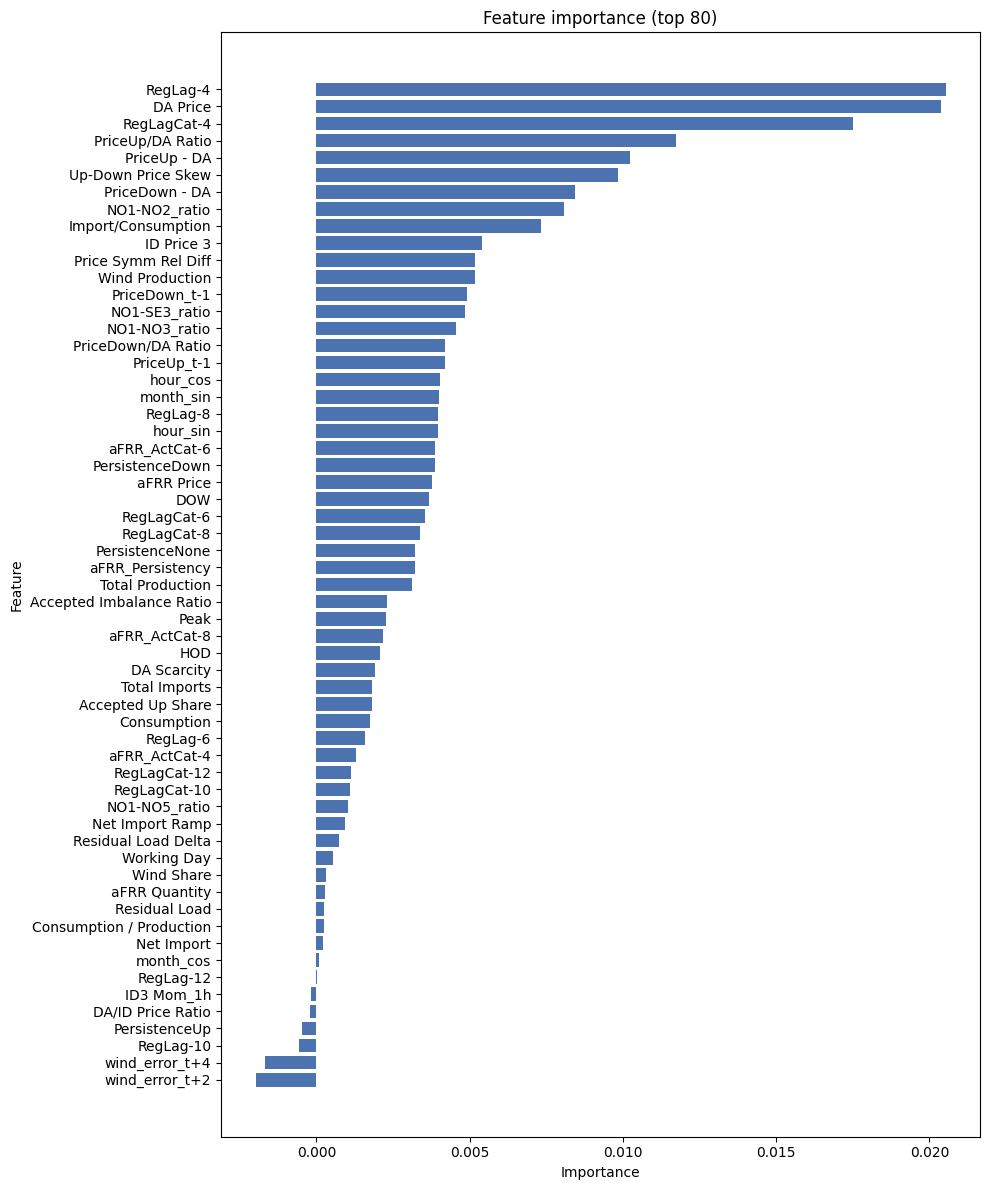

In [6]:
from IPython.display import Markdown, display
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Show feature importance once using the saved artifact if available,
# otherwise compute quickly as a fallback
fi_csv_path = (MODELS / "feature_importance.csv")
fi_df = None

if fi_csv_path.exists():
    fi_df = pd.read_csv(fi_csv_path)
else:
    try:
        from autogluon.tabular import TabularPredictor
        # Use existing predictor if present, otherwise load it
        predictor = predictor if 'predictor' in globals() else TabularPredictor.load(MODELS)
        # Try to load a cached dataset snapshot for FI; fall back to predictor's training data
        df_path = ROOT / 'reports' / 'dataframes' / 'multiclass_dataset.csv'
        if df_path.exists():
            eval_df = pd.read_csv(df_path)
            # Restrict to model features and drop label
            label = predictor.label
            feature_cols = [c for c in eval_df.columns if c != label and c in predictor.features()]
            eval_df = eval_df[feature_cols].dropna()
        else:
            # If no dataset snapshot, use predictor's training data
            eval_df = predictor.load_data_internal('train')[0]
        # Compute a fast FI with a short time limit
        fi_df = predictor.feature_importance(eval_df, time_limit=30)
    except Exception as e:
        fi_df = None
        print('Feature importance unavailable:', e)

if fi_df is not None and len(fi_df):
    # Normalize schema: ensure a 'feature' column is present
    tmp = fi_df.copy()
    if 'feature' not in tmp.columns:
        if 'Unnamed: 0' in tmp.columns:
            tmp = tmp.rename(columns={'Unnamed: 0': 'feature'})
        else:
            tmp = tmp.reset_index()
            if 'index' in tmp.columns:
                tmp = tmp.rename(columns={'index': 'feature'})
    # Ensure importance column exists
    if 'importance' not in tmp.columns and 'score' in tmp.columns:
        tmp = tmp.rename(columns={'score': 'importance'})

    # Display a single table (top 30)
    top_table = tmp.sort_values('importance', ascending=False).head(100)
    display(Markdown('## Feature importance (top 30)'))
    display(top_table[['feature', 'importance']])

    # Plot a single bar chart (top 80)
    top_plot = tmp.sort_values('importance', ascending=False).head(80)
    plt.figure(figsize=(10, 12))
    plt.barh(top_plot['feature'][::-1], top_plot['importance'][::-1], color='#4C72B0')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature importance (top 80)')
    plt.tight_layout()
    plt.show()
else:
    display(Markdown('## Feature importance unavailable'))





# Imbalance vs. Spot Price

== Class counts and correct predictions ==
true up:     1171 | pred up:     1358 | correct up:      528
true down:   2183 | pred down:   1996 | correct down:   1161
true none:   3110 | pred none:   3110 | correct none:   1752

== Precision/Recall/F1 per class ==
              precision    recall  f1-score   support

          up       0.39      0.45      0.42      1171
        down       0.58      0.53      0.56      2183
        none       0.56      0.56      0.56      3110

    accuracy                           0.53      6464
   macro avg       0.51      0.52      0.51      6464
weighted avg       0.54      0.53      0.53      6464

negatives in UP spread: 0
positives in DOWN spread: 0
                                                   name    n       mean       std         min        p05        p25        p50       p75       p95        max
                  Up Price - DA | correct UP (delivery)  528  18.867386 13.455566    0.120000   1.753500   8.430000  17.265000 26.162500 43.9515

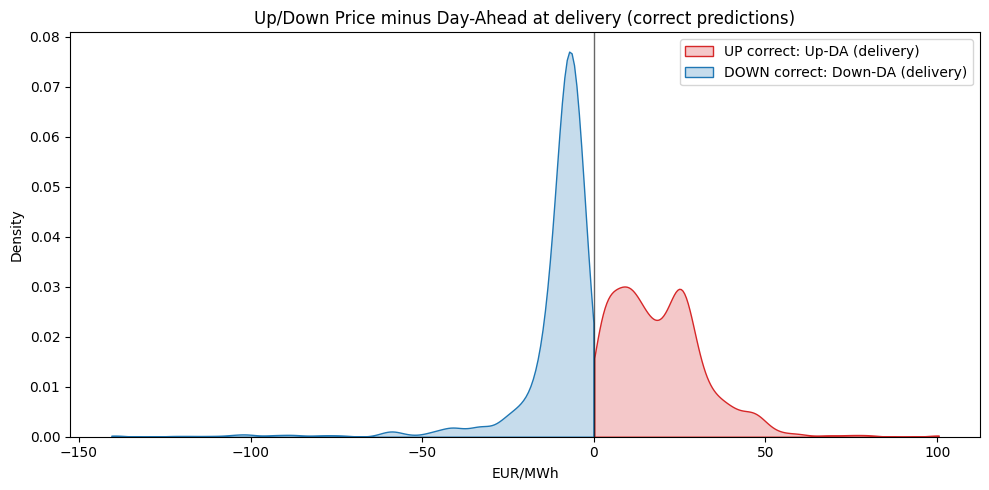

,name,n,mean,std,min,p05,p25,p50,p75,p95,max
0,Up Price - DA | correct UP (delivery),528,18.867386,13.455566,0.120000,1.753500,8.430000,17.265000,26.162500,43.951500,100.440000
1,Down Price - DA | correct DOWN (delivery),1160,-11.344698,14.659660,-140.540000,-33.151500,-11.282500,-7.620000,-5.360000,-1.749500,-0.130000
2,UP % change vs DA | correct UP (delivery) [per...,404,29.975715,26.941165,0.153886,2.028679,9.859155,24.873615,38.978035,75.835156,247.633136
3,DOWN % change vs DA | correct DOWN (delivery) ...,1134,-15.767480,16.188528,-145.433894,-45.997592,-16.612870,-11.515650,-8.126940,-3.085278,-0.223637


In [7]:
# Up/Down price minus spot (DA) for correct predictions + classification counts
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from src.evaluation.price_spread import plot_imbalance_vs_spot_price

# --- paths ---
REPO_ROOT = os.path.abspath(os.path.join('..'))
DATA_DIR = os.path.join(REPO_ROOT, 'data', 'raw')
# Use the same MODELS directory selected above
MODEL_DIR = str(MODELS)

SPLIT = 'test'  # 'val' or 'test'
PRED_FILE = os.path.join(MODEL_DIR, f'{SPLIT}_predictions.csv')

# --- load predictions ---
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f'Missing predictions file: {PRED_FILE}')
preds = pd.read_csv(PRED_FILE, index_col=0, parse_dates=True)
preds.index.name = 'Time'
label_col = preds.columns[0]  # e.g., 'RegClass+4'
pred_col = 'pred'
if pred_col not in preds.columns:
    raise ValueError("Expected 'pred' column in predictions CSV")

# Quick counts and confusion summary (uses full predictions, no joins)
y_true = preds[label_col]
y_pred = preds[pred_col]

correct_up = int(((y_pred == 'up') & (y_true == 'up')).sum())
correct_down = int(((y_pred == 'down') & (y_true == 'down')).sum())
correct_none = int(((y_pred == 'none') & (y_true == 'none')).sum())

n_true_up = int((y_true == 'up').sum())
n_true_down = int((y_true == 'down').sum())
n_true_none = int((y_true == 'none').sum())

n_pred_up = int((y_pred == 'up').sum())
n_pred_down = int((y_pred == 'down').sum())
n_pred_none = int((y_pred == 'none').sum())

print('== Class counts and correct predictions ==')
print(f"true up:   {n_true_up:6d} | pred up:   {n_pred_up:6d} | correct up:   {correct_up:6d}")
print(f"true down: {n_true_down:6d} | pred down: {n_pred_down:6d} | correct down: {correct_down:6d}")
print(f"true none: {n_true_none:6d} | pred none: {n_pred_none:6d} | correct none: {correct_none:6d}")

print('\n== Precision/Recall/F1 per class ==')
print(classification_report(y_true, y_pred, labels=['up','down','none'], zero_division=0))

# --- plot (refactored helper) ---
fig, ax, result, stats = plot_imbalance_vs_spot_price(
    preds=preds[[label_col, 'pred']],
    data_raw_dir=DATA_DIR,
    area='NO1',
    horizon_steps=4,
    include_2024=True,
    min_da_price=20.0,
    label_col=label_col,
    title='Up/Down Price minus Day-Ahead at delivery (correct predictions)',
    bw_adjust=0.8,
    print_stats=True,
 )
plt.show()

# Render the summary table as output too
stats['summary']

## Dataset-wide price spreads (no model filter)
This section plots and summarizes balancing-market price spreads relative to Day-Ahead, **for all timestamps** (not restricted to correct predictions).
- **Full 2024–2025**
- **From 2025-03-04 onward**

Loading preprocessed DataFrame from cache: c:\PythonProjects\rl_reserve_markets\upreg_classify\data\preprocessed\df_NO1.pkl
full 2024–2025 | n(true up)=7831 | n(true down)=19732
Plot x-limits (zoom q=0.995): [-105.72, 329.97]
full 2024–2025 | n(true up)=7831 | n(true down)=19732
Plot x-limits (zoom q=0.995): [-105.72, 329.97]


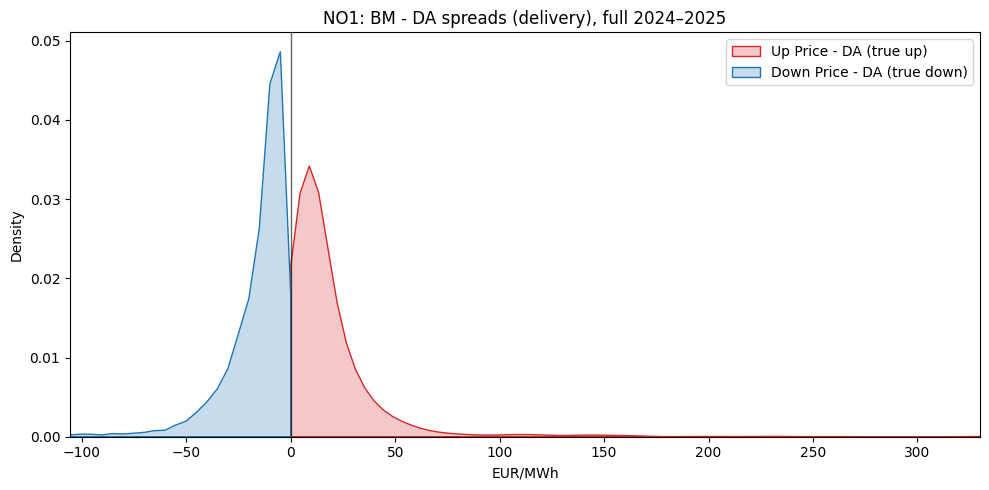

,name,n,mean,std,min,p05,p25,p50,p75,p95,max
0,Up Price - DA | correct UP (delivery),7831,20.575617,55.154987,0.000000,1.890000,6.000000,10.500000,19.900000,51.740000,881.810000
1,Down Price - DA | correct DOWN (delivery),19732,-16.260204,22.270525,-1000.000000,-45.278000,-20.452500,-10.710000,-5.980000,-1.730000,0.000000
2,UP % change vs DA | correct UP (delivery) [per...,6535,37.841065,69.429823,0.000000,2.419475,11.582903,22.278321,39.195548,122.993062,1088.413644
3,DOWN % change vs DA | correct DOWN (delivery) ...,16946,-30.379373,25.884108,-294.871795,-86.688723,-40.947402,-22.453903,-12.431520,-4.042466,0.000000


from 2025-03-04 | n(true up)=2901 | n(true down)=11326
Plot x-limits (zoom q=0.995): [-99.23, 501.25]


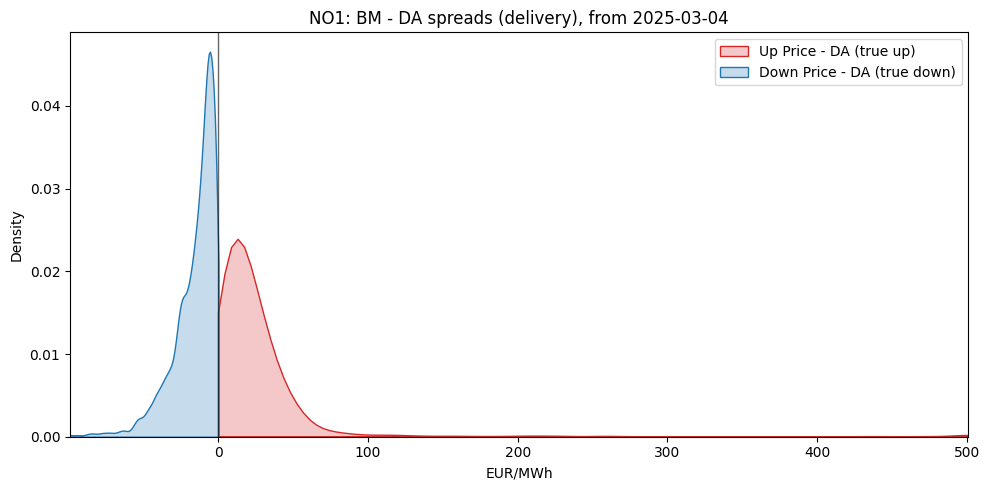

,name,n,mean,std,min,p05,p25,p50,p75,p95,max
0,Up Price - DA | correct UP (delivery),2901,26.214416,59.876019,0.000000,1.820000,8.040000,16.290000,28.870000,54.770000,870.540000
1,Down Price - DA | correct DOWN (delivery),11326,-16.624864,16.266271,-161.330000,-46.270000,-23.060000,-11.690000,-5.752500,-1.270000,0.000000
2,UP % change vs DA | correct UP (delivery) [per...,2376,41.090162,82.917465,0.000000,2.067903,11.892789,24.520347,41.388841,112.937370,1088.413644
3,DOWN % change vs DA | correct DOWN (delivery) ...,10694,-27.856823,25.140412,-294.871795,-80.916031,-39.036382,-19.825360,-10.099950,-2.959427,0.000000


In [8]:
# Dataset-wide: BM - DA spreads at delivery time (filtered by true direction)
from pathlib import Path
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import src.data.preprocess as dp
from src.data.preprocess import Config
import src.evaluation.price_spread as price_spread_mod

# Notebook kernels cache imports; force reload so new summary rows appear.
price_spread_mod = importlib.reload(price_spread_mod)
compute_delivery_spreads = price_spread_mod.compute_delivery_spreads
price_spread_stats = price_spread_mod.price_spread_stats

ROOT = Path.cwd().parent  # notebooks -> upreg_classify
DATA_RAW = ROOT / 'data' / 'raw'
DATA_PREPROCESSED = ROOT / 'data' / 'preprocessed'
CACHE_NO1 = DATA_PREPROCESSED / 'df_NO1.pkl'
AREA = 'NO1'  # change if needed
LABEL_COL = 'RegClass+4'
HORIZON_STEPS = 4  # matches label RegClass+4
MIN_DA_PRICE = 20.0

def _plot_spreads(spread_up: pd.Series, spread_down: pd.Series, title: str, zoom_quantile: float = 0.995):
    fig, ax = plt.subplots(figsize=(10, 5))
    if len(spread_up):
        sns.kdeplot(
            spread_up,
            fill=True,
            color='#d62728',
            label='Up Price - DA (true up)',
            clip=(0, None),
            cut=0,
            bw_adjust=0.8,
            ax=ax,
        )
    if len(spread_down):
        sns.kdeplot(
            spread_down,
            fill=True,
            color='#1f77b4',
            label='Down Price - DA (true down)',
            clip=(None, 0),
            cut=0,
            bw_adjust=0.8,
            ax=ax,
        )
    ax.axvline(0, color='k', lw=1, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('EUR/MWh')
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_ylim(bottom=0)

    # Zoom x-axis so extreme outliers don't flatten the plot (tables still show min/max)
    try:
        right = float(pd.to_numeric(spread_up, errors='coerce').dropna().quantile(zoom_quantile)) if len(spread_up) else np.nan
        left = float(pd.to_numeric(spread_down, errors='coerce').dropna().quantile(1 - zoom_quantile)) if len(spread_down) else np.nan
        if np.isfinite(left) and np.isfinite(right) and (left < 0) and (right > 0):
            ax.set_xlim(left, right)
            print(f'Plot x-limits (zoom q={zoom_quantile:.3f}): [{left:.2f}, {right:.2f}]')
    except Exception:
        pass

    fig.tight_layout()
    return fig, ax

def _run_dataset_window(title_suffix: str, df_window: pd.DataFrame):
    if LABEL_COL not in df_window.columns:
        raise KeyError(f"Missing label column '{LABEL_COL}' in preprocessed dataframe")

    # Make a 'preds' frame where pred == true label. This makes the helper's
    # 'correct UP' == 'true UP' and 'correct DOWN' == 'true DOWN'.
    y_true = df_window[LABEL_COL].astype(str)
    preds = pd.DataFrame({LABEL_COL: y_true, 'pred': y_true}, index=df_window.index)
    preds.index.name = 'Time'

    result = compute_delivery_spreads(
        preds=preds,
        data_raw_dir=DATA_RAW,
        area=AREA,
        horizon_steps=HORIZON_STEPS,
        include_2024=True,
        min_da_price=MIN_DA_PRICE,
        label_col=LABEL_COL,
        pred_col='pred',
    )
    stats = price_spread_stats(result)

    print(f"{title_suffix} | n(true up)={len(result.spread_up_correct)} | n(true down)={len(result.spread_down_correct)}")
    _fig, _ax = _plot_spreads(
        result.spread_up_correct,
        result.spread_down_correct,
        f"{AREA}: BM - DA spreads (delivery), {title_suffix}",
    )
    plt.show()
    display(stats['summary'])

# Load preprocessed DF (cached if available) and build two windows
cfg = Config()
df_full = dp.preprocess_all(cfg=cfg, cache_path=str(CACHE_NO1) if CACHE_NO1.exists() else None)

# Full 2024–2025 (whatever is present in df_full)
_run_dataset_window('full 2024–2025', df_full)

# From 2025-03-04 onward
df_march = df_full.loc[pd.Timestamp('2025-03-04'):]
_run_dataset_window('from 2025-03-04', df_march)

Launchpad-style data range: 2025-03-04 00:00:00 -> 2025-12-03 14:45:00 rows = 26360


## Correlation analysis: launchpad_full_from_2025_03_04

rows=5,000 | features=52 | numeric=47


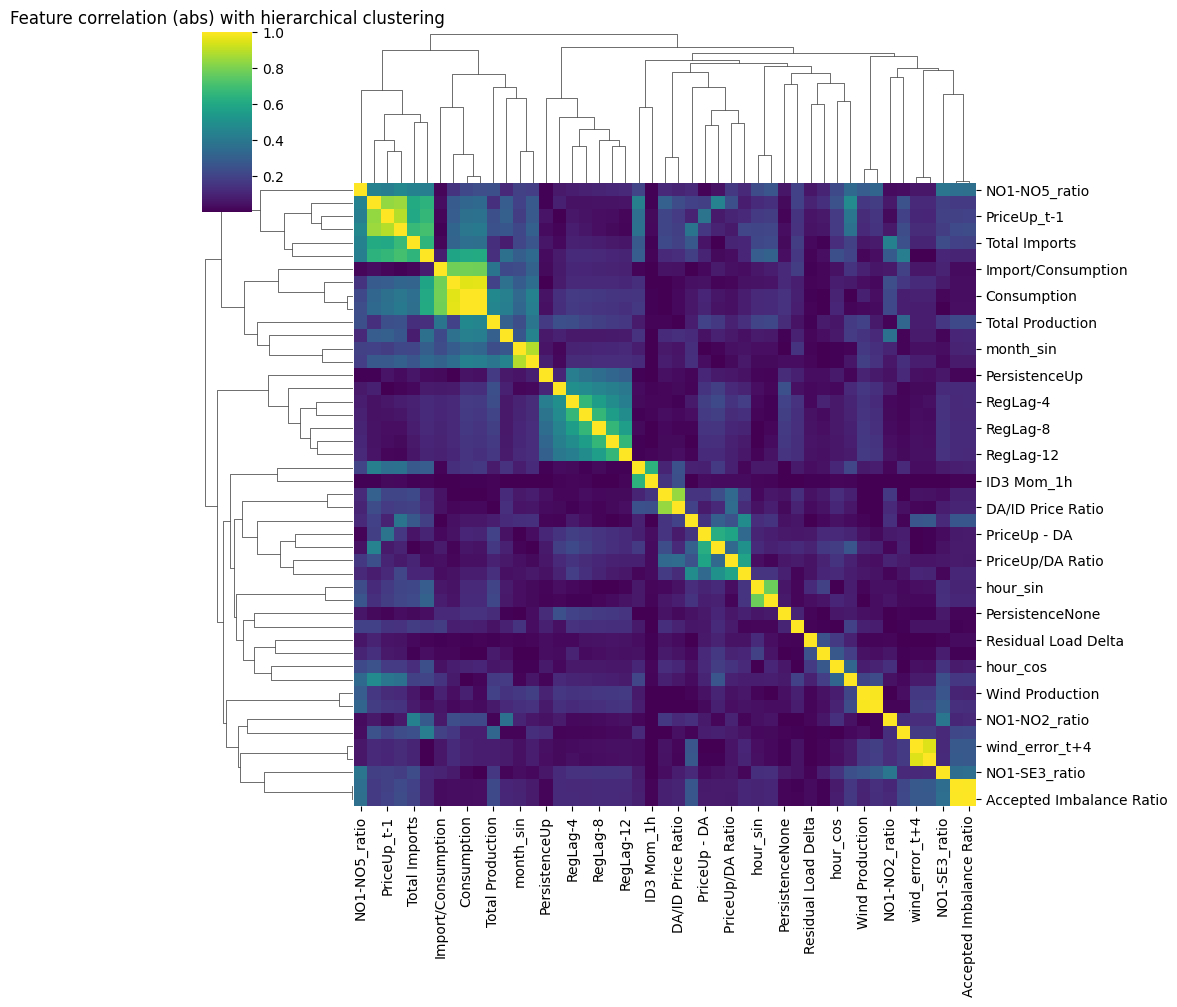

### Top correlated pairs (abs>=0.60)

,feature_a,feature_b,corr
1125,Consumption,Residual Load,0.997733
239,Accepted Imbalance Ratio,Accepted Up Share,0.994552
1154,Wind Production,Wind Share,0.989141
1313,Consumption / Production,Residual Load,0.957463
1108,Consumption,Consumption / Production,0.956545
1055,wind_error_t+2,wind_error_t+4,0.947148
383,PriceDown_t-1,PriceUp_t-1,0.888687
959,month_cos,month_sin,0.884542
1324,DA Price,PriceDown_t-1,0.850790
1487,DA/ID Price Ratio,Price Symm Rel Diff,0.841696


VIF buckets: {'nan': 47}
Top (by VIF):
                 feature  VIF bucket
           NO1-NO2_ratio  NaN    nan
           NO1-NO3_ratio  NaN    nan
           NO1-NO5_ratio  NaN    nan
           NO1-SE3_ratio  NaN    nan
       Accepted Up Share  NaN    nan
Accepted Imbalance Ratio  NaN    nan
      Up-Down Price Skew  NaN    nan
             PriceUp_t-1  NaN    nan
           PriceDown_t-1  NaN    nan
                RegLag-4  NaN    nan
                RegLag-6  NaN    nan
                RegLag-8  NaN    nan
               RegLag-10  NaN    nan
               RegLag-12  NaN    nan
           PersistenceUp  NaN    nan
         PersistenceDown  NaN    nan
         PersistenceNone  NaN    nan
                hour_sin  NaN    nan
                hour_cos  NaN    nan
               month_sin  NaN    nan
               month_cos  NaN    nan
          wind_error_t+4  NaN    nan
          wind_error_t+2  NaN    nan
             Consumption  NaN    nan
         Wind Production  NaN    nan

### VIF (top 30)

,feature,VIF,bucket
0,NO1-NO2_ratio,NaN,nan
1,NO1-NO3_ratio,NaN,nan
2,NO1-NO5_ratio,NaN,nan
3,NO1-SE3_ratio,NaN,nan
4,Accepted Up Share,NaN,nan
5,Accepted Imbalance Ratio,NaN,nan
6,Up-Down Price Skew,NaN,nan
7,PriceUp_t-1,NaN,nan
8,PriceDown_t-1,NaN,nan
9,RegLag-4,NaN,nan


PCA: components to reach 90% variance: 23


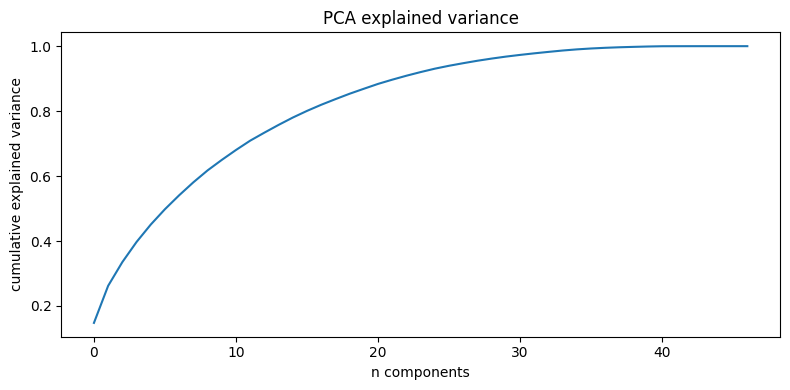

PCA: $k_{90\%}$ = 23 components

## Correlation analysis: launchpad_val

rows=5,000 | features=52 | numeric=47


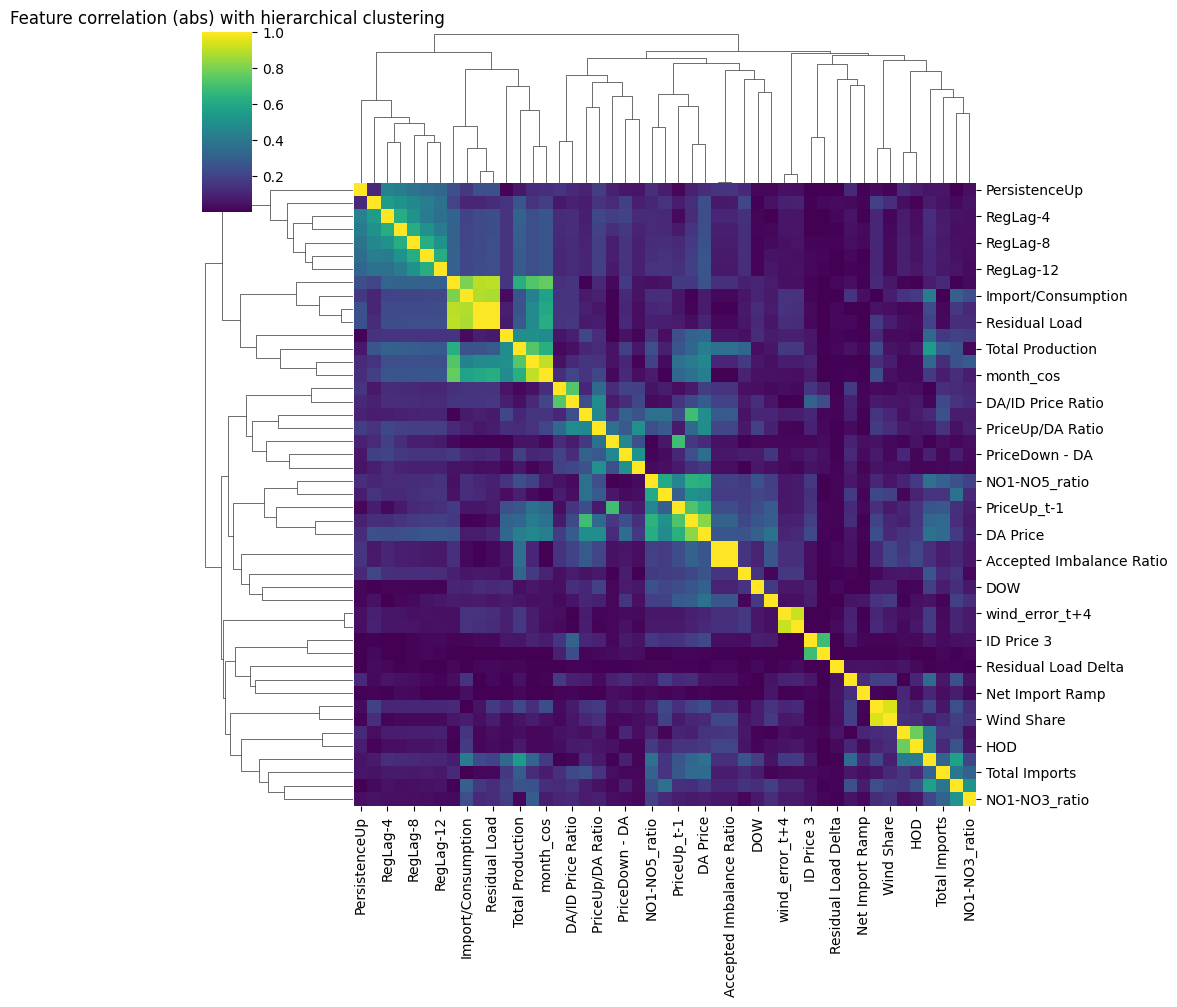

### Top correlated pairs (abs>=0.60)

,feature_a,feature_b,corr
239,Accepted Imbalance Ratio,Accepted Up Share,0.999075
1125,Consumption,Residual Load,0.992347
1154,Wind Production,Wind Share,0.945247
1055,wind_error_t+2,wind_error_t+4,0.920785
959,month_cos,month_sin,0.905142
1313,Consumption / Production,Residual Load,0.899192
1108,Consumption,Consumption / Production,0.897128
1124,Consumption,Import/Consumption,0.883908
2065,Import/Consumption,Residual Load,0.871738
1324,DA Price,PriceDown_t-1,0.824981


VIF buckets: {'nan': 47}
Top (by VIF):
                 feature  VIF bucket
           NO1-NO2_ratio  NaN    nan
           NO1-NO3_ratio  NaN    nan
           NO1-NO5_ratio  NaN    nan
           NO1-SE3_ratio  NaN    nan
       Accepted Up Share  NaN    nan
Accepted Imbalance Ratio  NaN    nan
      Up-Down Price Skew  NaN    nan
             PriceUp_t-1  NaN    nan
           PriceDown_t-1  NaN    nan
                RegLag-4  NaN    nan
                RegLag-6  NaN    nan
                RegLag-8  NaN    nan
               RegLag-10  NaN    nan
               RegLag-12  NaN    nan
           PersistenceUp  NaN    nan
         PersistenceDown  NaN    nan
         PersistenceNone  NaN    nan
                hour_sin  NaN    nan
                hour_cos  NaN    nan
               month_sin  NaN    nan
               month_cos  NaN    nan
          wind_error_t+4  NaN    nan
          wind_error_t+2  NaN    nan
             Consumption  NaN    nan
         Wind Production  NaN    nan

### VIF (top 30)

,feature,VIF,bucket
0,NO1-NO2_ratio,NaN,nan
1,NO1-NO3_ratio,NaN,nan
2,NO1-NO5_ratio,NaN,nan
3,NO1-SE3_ratio,NaN,nan
4,Accepted Up Share,NaN,nan
5,Accepted Imbalance Ratio,NaN,nan
6,Up-Down Price Skew,NaN,nan
7,PriceUp_t-1,NaN,nan
8,PriceDown_t-1,NaN,nan
9,RegLag-4,NaN,nan


PCA: components to reach 90% variance: 22


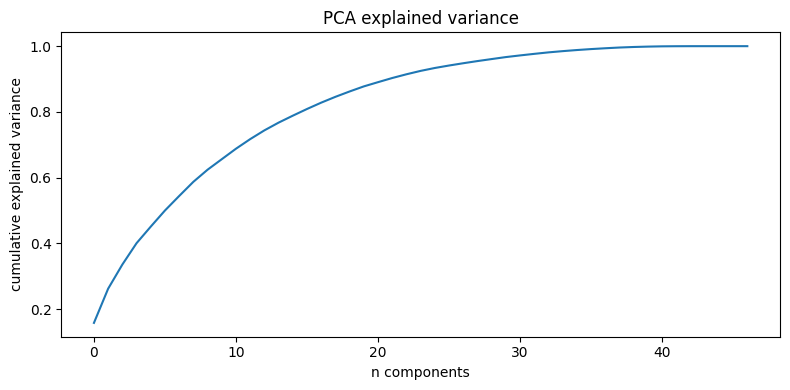

PCA: $k_{90\%}$ = 22 components

## Correlation analysis: launchpad_test

rows=5,000 | features=52 | numeric=47


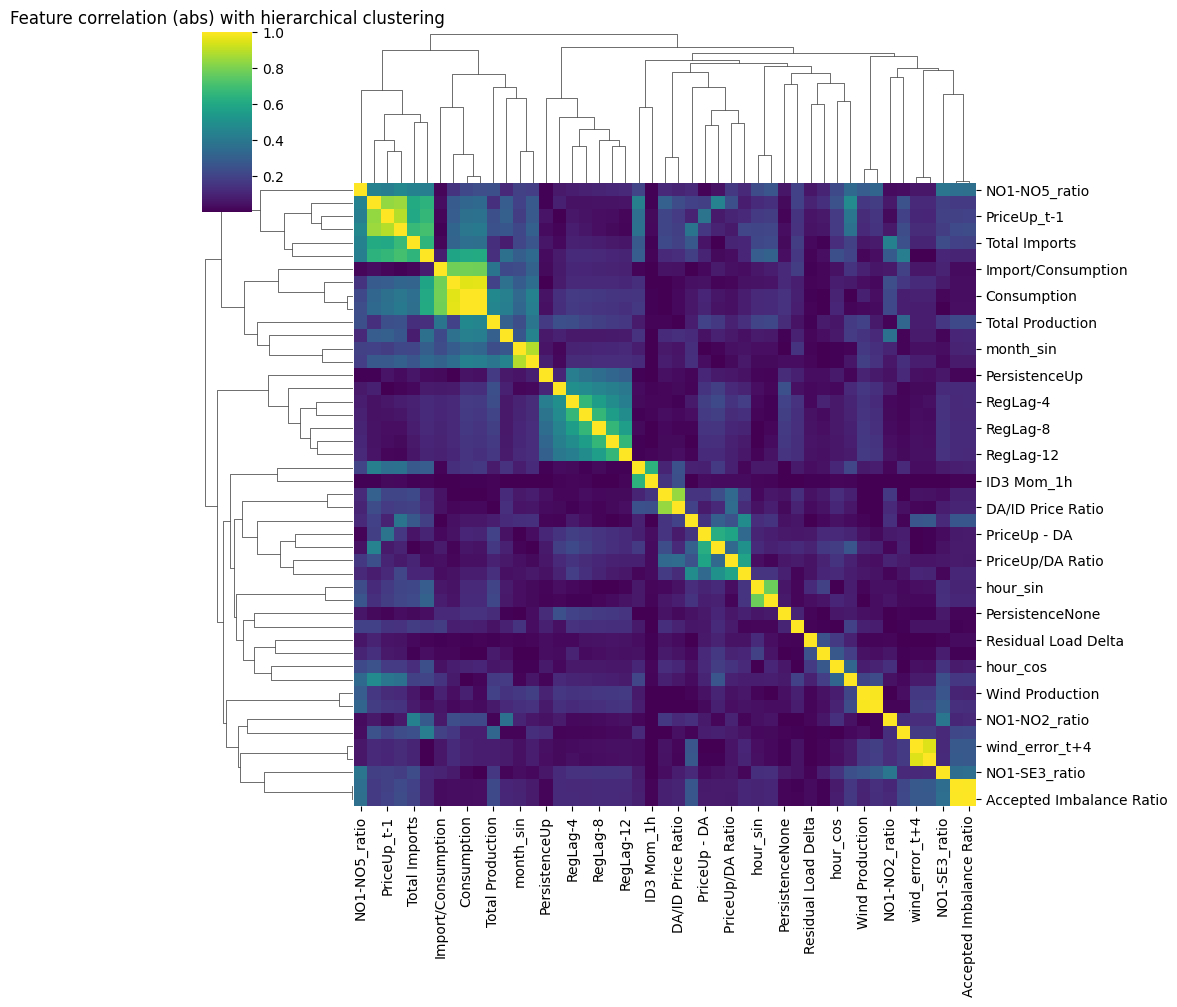

### Top correlated pairs (abs>=0.60)

,feature_a,feature_b,corr
1125,Consumption,Residual Load,0.997733
239,Accepted Imbalance Ratio,Accepted Up Share,0.994552
1154,Wind Production,Wind Share,0.989141
1313,Consumption / Production,Residual Load,0.957463
1108,Consumption,Consumption / Production,0.956545
1055,wind_error_t+2,wind_error_t+4,0.947148
383,PriceDown_t-1,PriceUp_t-1,0.888687
959,month_cos,month_sin,0.884542
1324,DA Price,PriceDown_t-1,0.850790
1487,DA/ID Price Ratio,Price Symm Rel Diff,0.841696


VIF buckets: {'nan': 47}
Top (by VIF):
                 feature  VIF bucket
           NO1-NO2_ratio  NaN    nan
           NO1-NO3_ratio  NaN    nan
           NO1-NO5_ratio  NaN    nan
           NO1-SE3_ratio  NaN    nan
       Accepted Up Share  NaN    nan
Accepted Imbalance Ratio  NaN    nan
      Up-Down Price Skew  NaN    nan
             PriceUp_t-1  NaN    nan
           PriceDown_t-1  NaN    nan
                RegLag-4  NaN    nan
                RegLag-6  NaN    nan
                RegLag-8  NaN    nan
               RegLag-10  NaN    nan
               RegLag-12  NaN    nan
           PersistenceUp  NaN    nan
         PersistenceDown  NaN    nan
         PersistenceNone  NaN    nan
                hour_sin  NaN    nan
                hour_cos  NaN    nan
               month_sin  NaN    nan
               month_cos  NaN    nan
          wind_error_t+4  NaN    nan
          wind_error_t+2  NaN    nan
             Consumption  NaN    nan
         Wind Production  NaN    nan

### VIF (top 30)

,feature,VIF,bucket
0,NO1-NO2_ratio,NaN,nan
1,NO1-NO3_ratio,NaN,nan
2,NO1-NO5_ratio,NaN,nan
3,NO1-SE3_ratio,NaN,nan
4,Accepted Up Share,NaN,nan
5,Accepted Imbalance Ratio,NaN,nan
6,Up-Down Price Skew,NaN,nan
7,PriceUp_t-1,NaN,nan
8,PriceDown_t-1,NaN,nan
9,RegLag-4,NaN,nan


PCA: components to reach 90% variance: 23


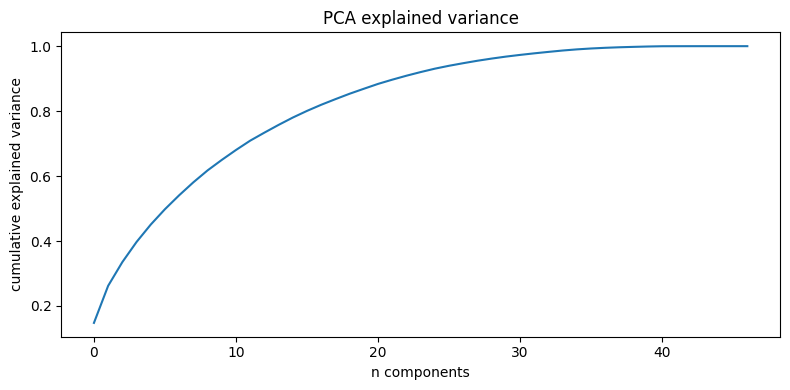

PCA: $k_{90\%}$ = 23 components

In [10]:
# Correlation analysis on the SAME dataset/split as Launchpad cell 4
import importlib
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Image

import src.evaluation.correlation as corr_mod
corr_mod = importlib.reload(corr_mod)

FIGS_DIR = globals().get('FIGS', ROOT / 'reports' / 'figures' / 'multiclass')
FIGS_DIR.mkdir(parents=True, exist_ok=True)


def _get_feature_cols(df_window: pd.DataFrame) -> list[str]:
    # Match Launchpad: features are all columns except label. If predictor exists, restrict to predictor.features().
    if 'predictor' in globals():
        return [c for c in predictor.features() if c in df_window.columns]
    return [c for c in df_window.columns if c != LABEL_COL]


def _run_corr(df_window: pd.DataFrame, window_name: str, max_rows: int | None = 5000, corr_threshold: float = 0.6):
    display(Markdown(f"## Correlation analysis: {window_name}"))

    feature_cols = _get_feature_cols(df_window)
    X = df_window[feature_cols].copy()
    X = X.dropna(subset=feature_cols)

    if max_rows is not None and len(X) > max_rows:
        X = X.tail(int(max_rows)).copy()

    Xn = X.select_dtypes(include=[np.number])
    print(f"rows={len(X):,} | features={len(feature_cols):,} | numeric={Xn.shape[1]:,}")

    corr_fig = FIGS_DIR / f"correlation_cluster_{window_name}.png"
    _cluster_map, top_pairs = corr_mod.compute_correlation_clusters(X, corr_fig)
    if corr_fig.exists():
        display(Image(filename=str(corr_fig)))

    if not top_pairs.empty:
        high = top_pairs[top_pairs['corr'] >= float(corr_threshold)].copy()
        display(Markdown(f"### Top correlated pairs (abs>={corr_threshold:.2f})"))
        display(high.head(50))

    vif_df = corr_mod.compute_vif(X, top_n=30)
    if not vif_df.empty:
        display(Markdown("### VIF (top 30)"))
        display(vif_df.head(30))

    pca_fig = FIGS_DIR / f"pca_explained_variance_{window_name}.png"
    evr = corr_mod.compute_pca_plot(X, pca_fig)
    if pca_fig.exists():
        display(Image(filename=str(pca_fig)))
    if evr is not None:
        display(Markdown(f"PCA: $k_{{90\\%}}$ = {int(np.searchsorted(np.cumsum(evr), 0.90) + 1)} components"))


# Match Launchpad cell 4: slice to >= 2025-03-04, then 0.6/0.2/0.2 chronological split
start = pd.Timestamp('2025-03-04')
df_lp = df_full.loc[start:].copy()
print('Launchpad-style data range:', df_lp.index.min(), '->', df_lp.index.max(), 'rows =', len(df_lp))

n = len(df_lp)
val_start = int(n * 0.6)
test_start = int(n * 0.8)

df_val = df_lp.iloc[val_start:test_start]
df_test = df_lp.iloc[test_start:]

_run_corr(df_lp, window_name="launchpad_full_from_2025_03_04")
_run_corr(df_val, window_name="launchpad_val")
_run_corr(df_test, window_name="launchpad_test")


In [ ]:
display(Markdown('## Transitions captured from none to up/down'))

# Transitions captured: none -> up / none -> down from t+3 to t+4
import pandas as pd

# y_true is RegClass+4 at index t (class at t+4). Previous step (t+3) is y_true shifted by +1 index.
prev_true = y_true.shift(1)
print(len(preds))

# Masks for transitions from 'none' at t+3 to target at t+4
none_to_up = prev_true.eq('none') & y_true.eq('up')
none_to_down = prev_true.eq('none') & y_true.eq('down')

# Captured by model (predicted correctly at t+4)
captured_up = (none_to_up & y_pred.eq('up')).sum()
cap_total_up = int(none_to_up.sum())
up_pct = (captured_up / cap_total_up * 100.0) if cap_total_up else 0.0

captured_down = (none_to_down & y_pred.eq('down')).sum()
cap_total_down = int(none_to_down.sum())
down_pct = (captured_down / cap_total_down * 100.0) if cap_total_down else 0.0

print(f"None -> Up captured: {captured_up}/{cap_total_up} ({up_pct:.1f}%)")
print(f"None -> Down captured: {captured_down}/{cap_total_down} ({down_pct:.1f}%)")


## Transitions captured from none to up/down

6464
None -> Up captured: 80/278 (28.8%)
None -> Down captured: 143/353 (40.5%)


In [ ]:
# Explore decision policy alpha (up multiplier) and recompute metrics
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import display, Markdown

.0
def _load_predictions(split: str) -> pd.DataFrame:
    """Load saved predictions CSV for the given split (val/test)."""
    path = MODELS / f"{split}_predictions.csv"
    if not path.exists():
        raise FileNotFoundError(f"Missing predictions file: {path}")
    df = pd.read_csv(path)
    return df

.0
def _get_label_and_proba_cols(df: pd.DataFrame):
    # Label column: prefer 'RegClass+4' if present, else the first non-proba, non-'pred'
    label_col = 'RegClass+4' if 'RegClass+4' in df.columns else next(c for c in df.columns if not c.startswith('p_') and c != 'pred')
    proba_cols = [c for c in df.columns if c.startswith('p_')]
    # Ensure required columns exist
    if 'p_up' not in proba_cols:
        raise ValueError("Expected 'p_up' column in predictions (probabilities).")
    return label_col, proba_cols

.0
def predict_with_alpha(df: pd.DataFrame, alpha: float):
    label_col, proba_cols = _get_label_and_proba_cols(df)
    proba = df[proba_cols].copy()
    # Multiply UP probability by alpha then argmax across p_* columns
    proba['p_up'] = proba['p_up'] * float(alpha)
    y_pred = proba.idxmax(axis=1).str.replace('p_', '', regex=False)
    y_true = df[label_col].astype(str)
    return y_true, y_pred

.0
def metrics_for_alpha(df: pd.DataFrame, alpha: float) -> dict:
    y_true, y_pred = predict_with_alpha(df, alpha)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    f1_up = f1_score((y_true == 'up'), (y_pred == 'up'), zero_division=0)
    return {'alpha': alpha, 'f1_macro': f1m, 'f1_up': f1_up, 'accuracy': acc}

.0
def sweep_alphas(split: str = 'val', alphas=None) -> pd.DataFrame:
    if alphas is None:
        # A compact sweep around common useful values
        alphas = [0.75, 0.9, 1.0, 1.1, 1.175, 1.25, 1.3, 1.375, 1.45, 1.5, 1.75, 2.0, 2.25, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7]
    df = _load_predictions(split)
    rows = [metrics_for_alpha(df, a) for a in alphas]
    res = pd.DataFrame(rows)
    return res

.0
# Run a quick sweep on validation and test
display(Markdown('## Alpha sweep (validation)'))
val_res = sweep_alphas('val')
display(val_res.sort_values('f1_macro', ascending=False).reset_index(drop=True))

.0
display(Markdown('## Alpha sweep (test)'))
if (MODELS / 'test_predictions.csv').exists():
    test_res = sweep_alphas('test')
    display(test_res.sort_values('f1_macro', ascending=False).reset_index(drop=True))
else:
    print('test_predictions.csv not found; run evaluation to generate it.')

.0
# Optional interactive slider if ipywidgets is available
try:
    import ipywidgets as widgets
    @widgets.interact(alpha=widgets.FloatSlider(min=0.5, max=3.0, step=0.05, value=1.0), split=widgets.ToggleButtons(options=['val','test'], value='val'))
    def interactive_alpha(alpha=1.0, split='val'):
        df = _load_predictions(split)
        m = metrics_for_alpha(df, alpha)
        display(Markdown(f"### Split: {split} | alpha: {alpha:.2f}"))
        print(m)
        # Print a compact report as well
        y_true, y_pred = predict_with_alpha(df, alpha)
        print(classification_report(y_true, y_pred, labels=['up','down','none'], zero_division=0))
except Exception as _e:
    pass

## Alpha sweep (validation)

,alpha,f1_macro,f1_up,accuracy
0,2.250,0.504444,0.262295,0.591057
1,2.500,0.502613,0.271817,0.580381
2,2.000,0.489382,0.208451,0.594925
3,3.000,0.488081,0.272432,0.549745
4,1.750,0.483685,0.178067,0.603744
5,1.500,0.470615,0.133011,0.606994
6,3.500,0.470227,0.271348,0.517407
7,1.450,0.468638,0.125926,0.607767
8,1.375,0.466661,0.118537,0.608696
9,1.300,0.464932,0.111255,0.610088


## Alpha sweep (test)

,alpha,f1_macro,f1_up,accuracy
0,2.250,0.519963,0.411765,0.549350
1,2.000,0.519188,0.389786,0.560489
2,2.500,0.512179,0.417556,0.532333
3,1.750,0.506349,0.341434,0.563583
4,3.000,0.490890,0.418649,0.498144
5,1.500,0.484779,0.270343,0.562964
6,1.450,0.479840,0.253968,0.562964
7,3.500,0.467861,0.415939,0.468750
8,1.375,0.467849,0.218415,0.560179
9,1.300,0.456991,0.186627,0.557704


interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0, min=0.5, step=0.05), ToggleButtons(…

Launchpad-style data range: 2025-03-04 00:00:00 -> 2025-12-03 14:45:00 rows = 26360


## Correlation analysis: launchpad_full_from_2025_03_04

rows=5,000 | features=114 | numeric=103


c:\PythonProjects\rl_reserve_markets\.venv1\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\PythonProjects\rl_reserve_markets\.venv1\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


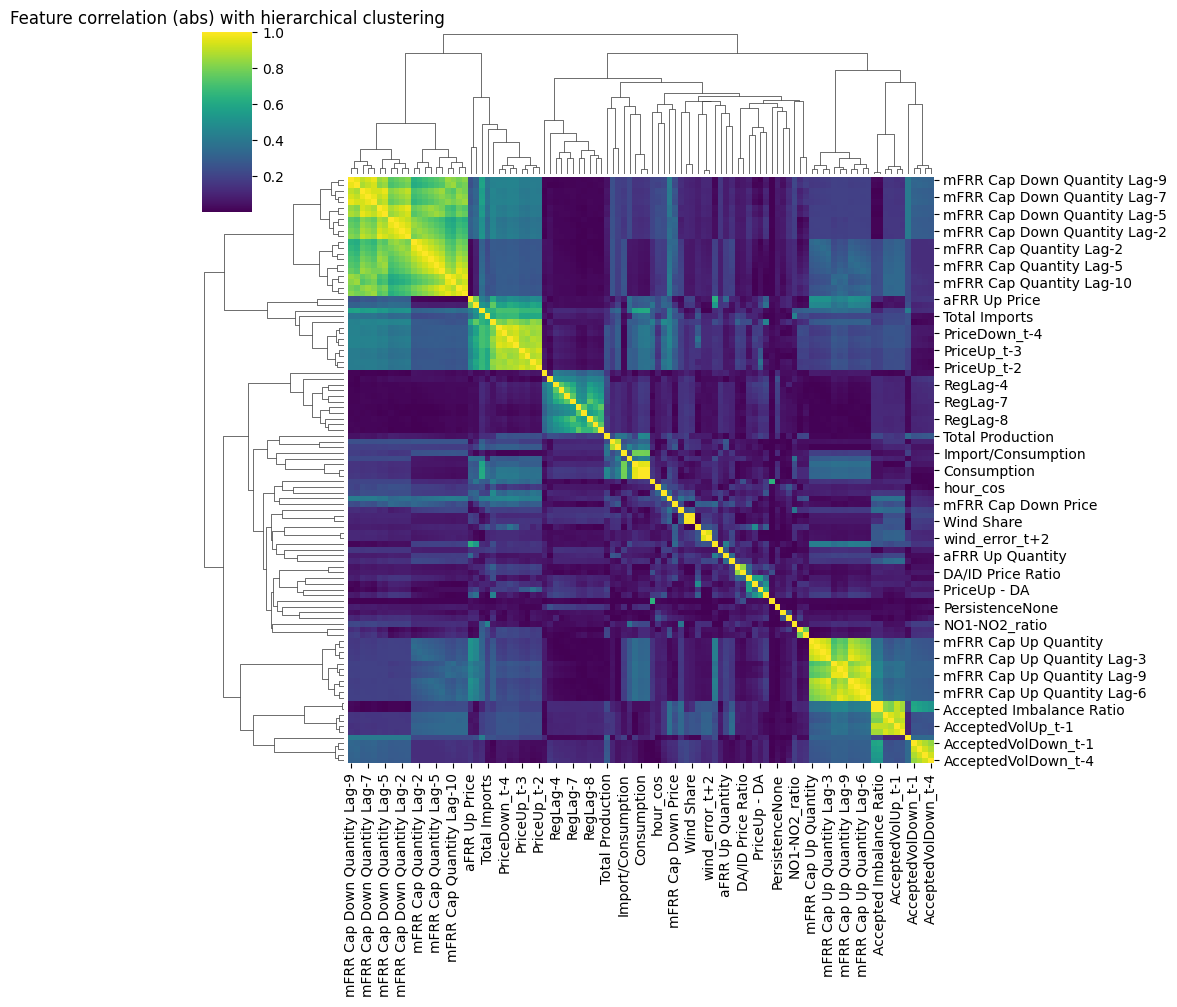

### Top correlated pairs (abs>=0.60)

,feature_a,feature_b,corr
4323,Consumption,Residual Load,0.997733
519,Accepted Imbalance Ratio,Accepted Up Share,0.994552
4370,Wind Production,Wind Share,0.989141
6034,mFRR Cap Down Quantity,mFRR Cap Down Quantity Lag-1,0.968371
6243,mFRR Cap Down Quantity Lag-1,mFRR Cap Down Quantity Lag-2,0.968353
6555,mFRR Cap Down Quantity Lag-2,mFRR Cap Down Quantity Lag-3,0.968334
6867,mFRR Cap Down Quantity Lag-3,mFRR Cap Down Quantity Lag-4,0.968316
7179,mFRR Cap Down Quantity Lag-4,mFRR Cap Down Quantity Lag-5,0.968270
7491,mFRR Cap Down Quantity Lag-5,mFRR Cap Down Quantity Lag-6,0.968256
7803,mFRR Cap Down Quantity Lag-6,mFRR Cap Down Quantity Lag-7,0.968242


VIF buckets: {'nan': 103}
Top (by VIF):
                 feature  VIF bucket
           NO1-NO2_ratio  NaN    nan
           NO1-NO3_ratio  NaN    nan
           NO1-NO5_ratio  NaN    nan
           NO1-SE3_ratio  NaN    nan
       Accepted Up Share  NaN    nan
Accepted Imbalance Ratio  NaN    nan
       AcceptedVolUp_t-1  NaN    nan
     AcceptedVolDown_t-1  NaN    nan
       AcceptedVolUp_t-2  NaN    nan
     AcceptedVolDown_t-2  NaN    nan
       AcceptedVolUp_t-3  NaN    nan
     AcceptedVolDown_t-3  NaN    nan
       AcceptedVolUp_t-4  NaN    nan
     AcceptedVolDown_t-4  NaN    nan
      Up-Down Price Skew  NaN    nan
             PriceUp_t-1  NaN    nan
           PriceDown_t-1  NaN    nan
             PriceUp_t-2  NaN    nan
           PriceDown_t-2  NaN    nan
             PriceUp_t-3  NaN    nan
           PriceDown_t-3  NaN    nan
             PriceUp_t-4  NaN    nan
           PriceDown_t-4  NaN    nan
                RegLag-4  NaN    nan
                RegLag-5  NaN    na

### VIF (top 30)

,feature,VIF,bucket
0,NO1-NO2_ratio,NaN,nan
1,NO1-NO3_ratio,NaN,nan
2,NO1-NO5_ratio,NaN,nan
3,NO1-SE3_ratio,NaN,nan
4,Accepted Up Share,NaN,nan
5,Accepted Imbalance Ratio,NaN,nan
6,AcceptedVolUp_t-1,NaN,nan
7,AcceptedVolDown_t-1,NaN,nan
8,AcceptedVolUp_t-2,NaN,nan
9,AcceptedVolDown_t-2,NaN,nan


PCA: components to reach 90% variance: 29



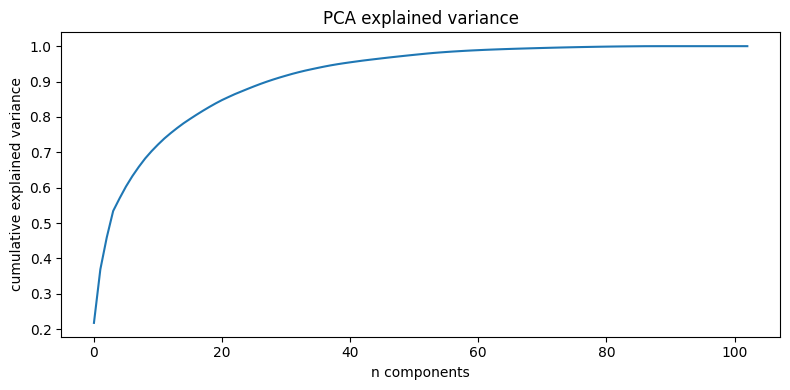

PCA: $k_{90\%}$ = 29 components

## Correlation analysis: launchpad_val

rows=5,000 | features=114 | numeric=103


c:\PythonProjects\rl_reserve_markets\.venv1\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\PythonProjects\rl_reserve_markets\.venv1\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


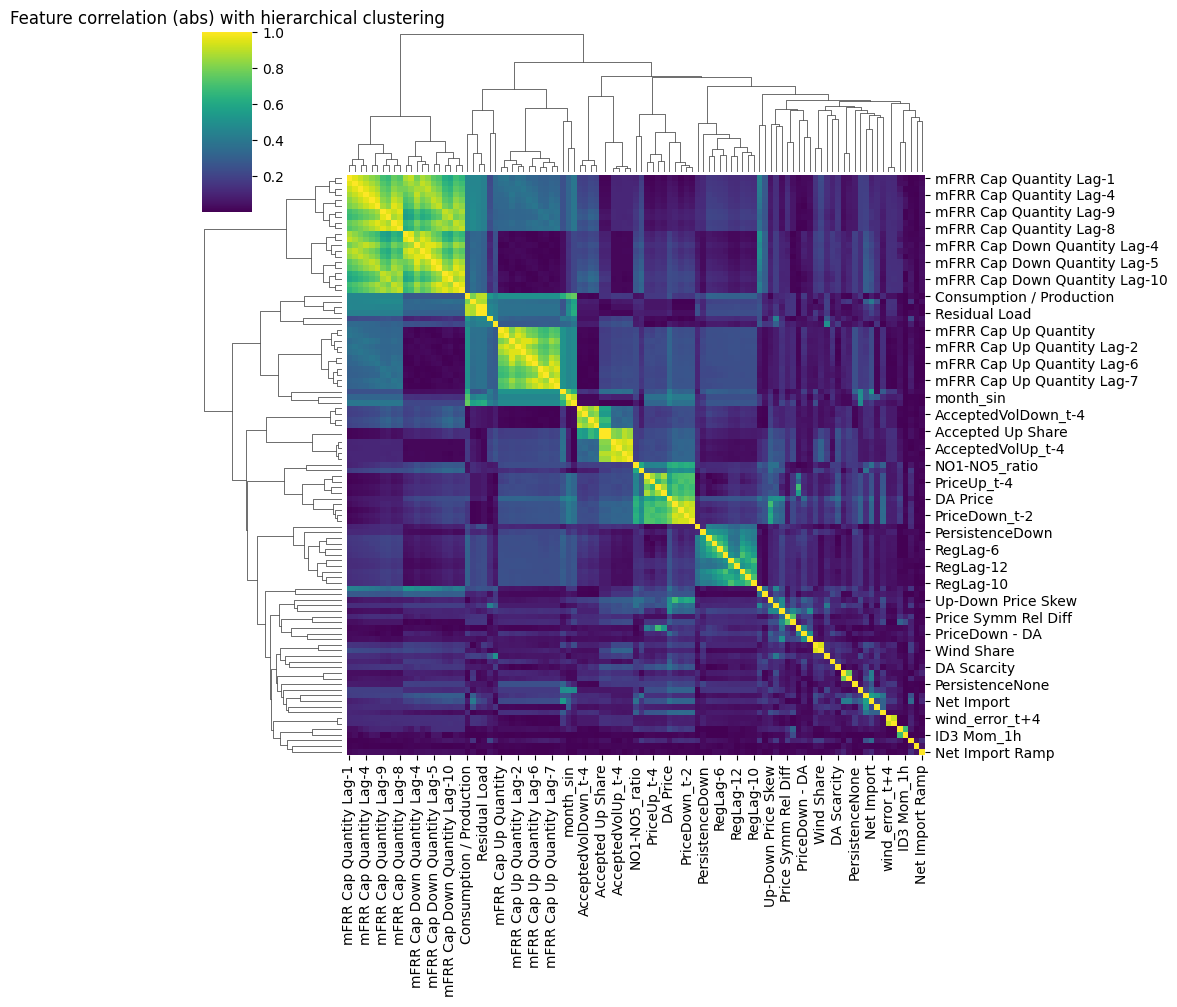

### Top correlated pairs (abs>=0.60)

,feature_a,feature_b,corr
519,Accepted Imbalance Ratio,Accepted Up Share,0.999075
4323,Consumption,Residual Load,0.992347
6347,mFRR Cap Quantity Lag-1,mFRR Cap Quantity Lag-2,0.956321
6659,mFRR Cap Quantity Lag-2,mFRR Cap Quantity Lag-3,0.956298
6971,mFRR Cap Quantity Lag-3,mFRR Cap Quantity Lag-4,0.956276
7283,mFRR Cap Quantity Lag-4,mFRR Cap Quantity Lag-5,0.956184
7595,mFRR Cap Quantity Lag-5,mFRR Cap Quantity Lag-6,0.956183
7907,mFRR Cap Quantity Lag-6,mFRR Cap Quantity Lag-7,0.956183
8219,mFRR Cap Quantity Lag-7,mFRR Cap Quantity Lag-8,0.956182
9149,mFRR Cap Quantity Lag-10,mFRR Cap Quantity Lag-9,0.956061


VIF buckets: {'nan': 103}
Top (by VIF):
                 feature  VIF bucket
           NO1-NO2_ratio  NaN    nan
           NO1-NO3_ratio  NaN    nan
           NO1-NO5_ratio  NaN    nan
           NO1-SE3_ratio  NaN    nan
       Accepted Up Share  NaN    nan
Accepted Imbalance Ratio  NaN    nan
       AcceptedVolUp_t-1  NaN    nan
     AcceptedVolDown_t-1  NaN    nan
       AcceptedVolUp_t-2  NaN    nan
     AcceptedVolDown_t-2  NaN    nan
       AcceptedVolUp_t-3  NaN    nan
     AcceptedVolDown_t-3  NaN    nan
       AcceptedVolUp_t-4  NaN    nan
     AcceptedVolDown_t-4  NaN    nan
      Up-Down Price Skew  NaN    nan
             PriceUp_t-1  NaN    nan
           PriceDown_t-1  NaN    nan
             PriceUp_t-2  NaN    nan
           PriceDown_t-2  NaN    nan
             PriceUp_t-3  NaN    nan
           PriceDown_t-3  NaN    nan
             PriceUp_t-4  NaN    nan
           PriceDown_t-4  NaN    nan
                RegLag-4  NaN    nan
                RegLag-5  NaN    na

### VIF (top 30)

,feature,VIF,bucket
0,NO1-NO2_ratio,NaN,nan
1,NO1-NO3_ratio,NaN,nan
2,NO1-NO5_ratio,NaN,nan
3,NO1-SE3_ratio,NaN,nan
4,Accepted Up Share,NaN,nan
5,Accepted Imbalance Ratio,NaN,nan
6,AcceptedVolUp_t-1,NaN,nan
7,AcceptedVolDown_t-1,NaN,nan
8,AcceptedVolUp_t-2,NaN,nan
9,AcceptedVolDown_t-2,NaN,nan


PCA: components to reach 90% variance: 31


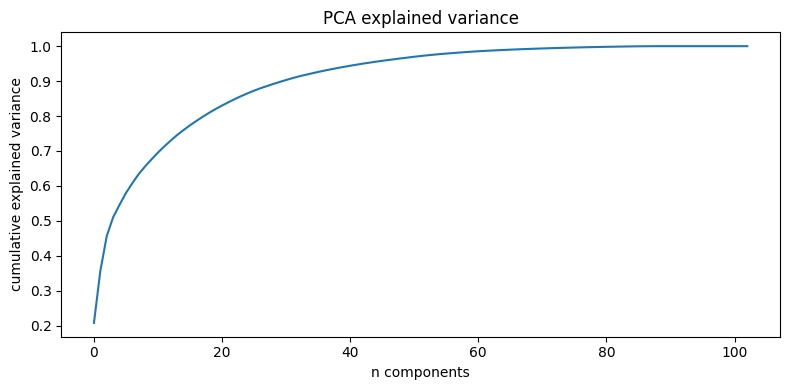

PCA: $k_{90\%}$ = 31 components

## Correlation analysis: launchpad_test

rows=5,000 | features=114 | numeric=103


c:\PythonProjects\rl_reserve_markets\.venv1\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\PythonProjects\rl_reserve_markets\.venv1\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


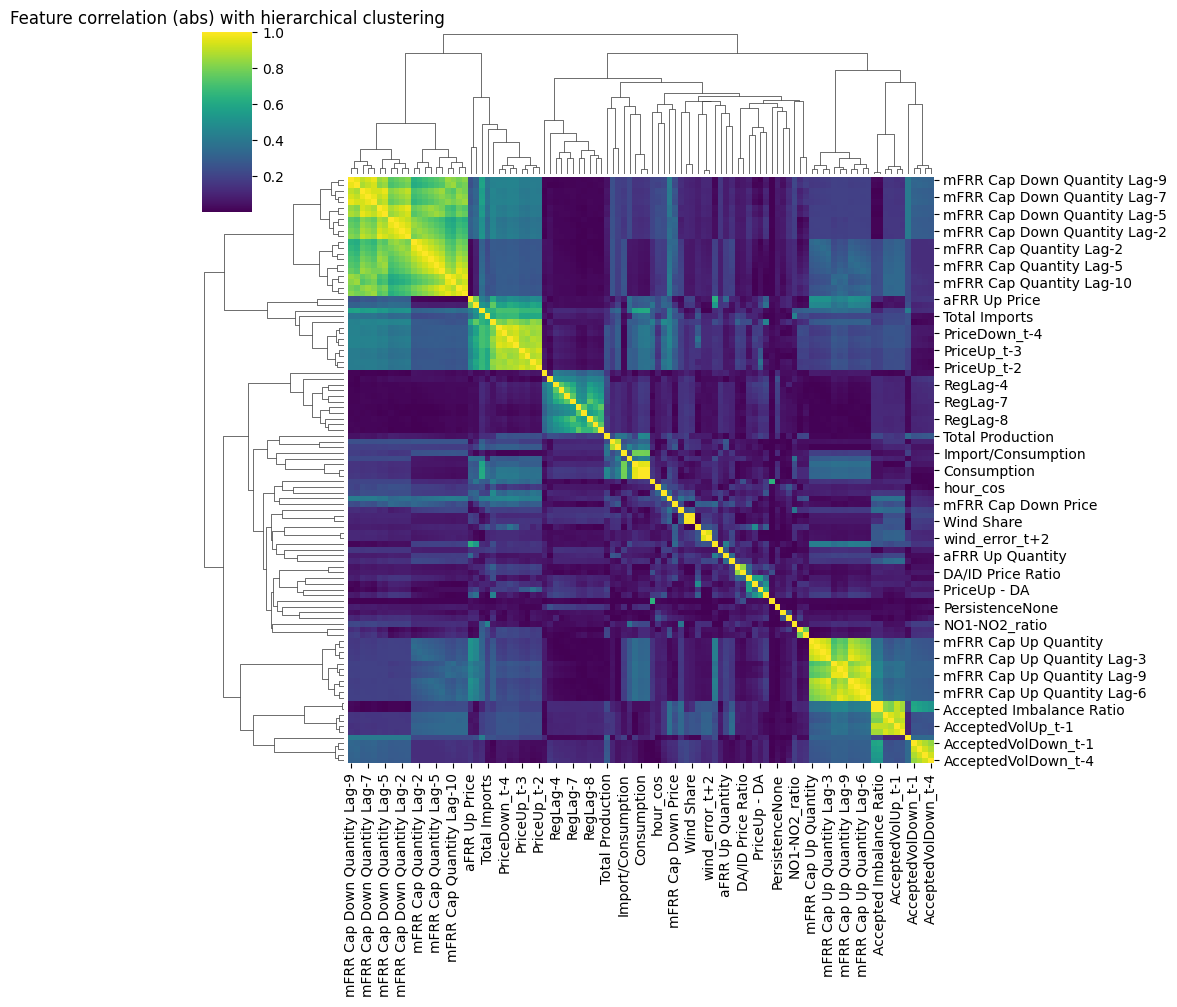

### Top correlated pairs (abs>=0.60)

,feature_a,feature_b,corr
4323,Consumption,Residual Load,0.997733
519,Accepted Imbalance Ratio,Accepted Up Share,0.994552
4370,Wind Production,Wind Share,0.989141
6034,mFRR Cap Down Quantity,mFRR Cap Down Quantity Lag-1,0.968371
6243,mFRR Cap Down Quantity Lag-1,mFRR Cap Down Quantity Lag-2,0.968353
6555,mFRR Cap Down Quantity Lag-2,mFRR Cap Down Quantity Lag-3,0.968334
6867,mFRR Cap Down Quantity Lag-3,mFRR Cap Down Quantity Lag-4,0.968316
7179,mFRR Cap Down Quantity Lag-4,mFRR Cap Down Quantity Lag-5,0.968270
7491,mFRR Cap Down Quantity Lag-5,mFRR Cap Down Quantity Lag-6,0.968256
7803,mFRR Cap Down Quantity Lag-6,mFRR Cap Down Quantity Lag-7,0.968242


VIF buckets: {'nan': 103}
Top (by VIF):
                 feature  VIF bucket
           NO1-NO2_ratio  NaN    nan
           NO1-NO3_ratio  NaN    nan
           NO1-NO5_ratio  NaN    nan
           NO1-SE3_ratio  NaN    nan
       Accepted Up Share  NaN    nan
Accepted Imbalance Ratio  NaN    nan
       AcceptedVolUp_t-1  NaN    nan
     AcceptedVolDown_t-1  NaN    nan
       AcceptedVolUp_t-2  NaN    nan
     AcceptedVolDown_t-2  NaN    nan
       AcceptedVolUp_t-3  NaN    nan
     AcceptedVolDown_t-3  NaN    nan
       AcceptedVolUp_t-4  NaN    nan
     AcceptedVolDown_t-4  NaN    nan
      Up-Down Price Skew  NaN    nan
             PriceUp_t-1  NaN    nan
           PriceDown_t-1  NaN    nan
             PriceUp_t-2  NaN    nan
           PriceDown_t-2  NaN    nan
             PriceUp_t-3  NaN    nan
           PriceDown_t-3  NaN    nan
             PriceUp_t-4  NaN    nan
           PriceDown_t-4  NaN    nan
                RegLag-4  NaN    nan
                RegLag-5  NaN    na

### VIF (top 30)

,feature,VIF,bucket
0,NO1-NO2_ratio,NaN,nan
1,NO1-NO3_ratio,NaN,nan
2,NO1-NO5_ratio,NaN,nan
3,NO1-SE3_ratio,NaN,nan
4,Accepted Up Share,NaN,nan
5,Accepted Imbalance Ratio,NaN,nan
6,AcceptedVolUp_t-1,NaN,nan
7,AcceptedVolDown_t-1,NaN,nan
8,AcceptedVolUp_t-2,NaN,nan
9,AcceptedVolDown_t-2,NaN,nan


PCA: components to reach 90% variance: 29


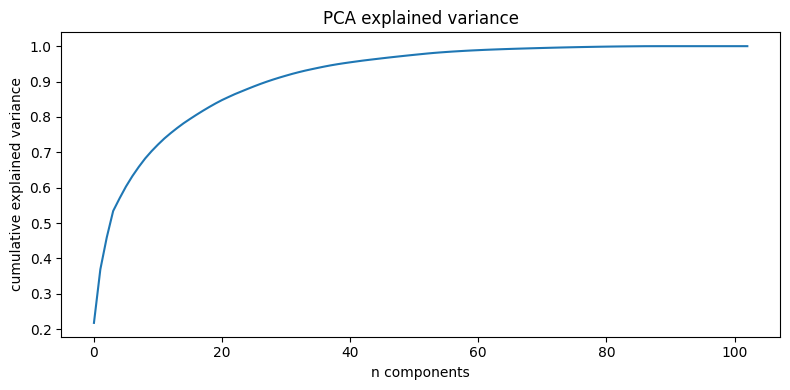

PCA: $k_{90\%}$ = 29 components

In [3]:
# Correlation analysis on the SAME dataset/split as Launchpad cell 4
import importlib
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Image

import src.evaluation.correlation as corr_mod
corr_mod = importlib.reload(corr_mod)

# Make this cell runnable standalone
from pathlib import Path
ROOT = globals().get('ROOT', Path.cwd().parent)
LABEL_COL = globals().get('LABEL_COL', 'RegClass+4')
if 'df_full' not in globals():
    import src.data.preprocess as dp
    from src.data.preprocess import Config
    CACHE_NO1 = ROOT / 'data' / 'preprocessed' / 'df_NO1.pkl'
    cfg = Config()
    df_full = dp.preprocess_all(cfg=cfg, cache_path=str(CACHE_NO1) if CACHE_NO1.exists() else None)

FIGS_DIR = globals().get('FIGS', ROOT / 'reports' / 'figures' / 'multiclass')
FIGS_DIR.mkdir(parents=True, exist_ok=True)


def _get_feature_cols(df_window: pd.DataFrame) -> list[str]:
    # Match Launchpad: features are all columns except label. If predictor exists, restrict to predictor.features().
    if 'predictor' in globals():
        return [c for c in predictor.features() if c in df_window.columns]
    return [c for c in df_window.columns if c != LABEL_COL]


def _run_corr(df_window: pd.DataFrame, window_name: str, max_rows: int | None = 5000, corr_threshold: float = 0.6):
    display(Markdown(f"## Correlation analysis: {window_name}"))

    feature_cols = _get_feature_cols(df_window)
    X = df_window[feature_cols].copy()
    X = X.dropna(subset=feature_cols)

    if max_rows is not None and len(X) > max_rows:
        X = X.tail(int(max_rows)).copy()

    Xn = X.select_dtypes(include=[np.number])
    print(f"rows={len(X):,} | features={len(feature_cols):,} | numeric={Xn.shape[1]:,}")

    corr_fig = FIGS_DIR / f"correlation_cluster_{window_name}.png"
    _cluster_map, top_pairs = corr_mod.compute_correlation_clusters(X, corr_fig)
    if corr_fig.exists():
        display(Image(filename=str(corr_fig)))

    if not top_pairs.empty:
        high = top_pairs[top_pairs['corr'] >= float(corr_threshold)].copy()
        display(Markdown(f"### Top correlated pairs (abs>={corr_threshold:.2f})"))
        display(high.head(50))

    vif_df = corr_mod.compute_vif(X, top_n=30)
    if not vif_df.empty:
        display(Markdown("### VIF (top 30)"))
        display(vif_df.head(30))

    pca_fig = FIGS_DIR / f"pca_explained_variance_{window_name}.png"
    evr = corr_mod.compute_pca_plot(X, pca_fig)
    if pca_fig.exists():
        display(Image(filename=str(pca_fig)))
    if evr is not None:
        display(Markdown(f"PCA: $k_{{90\\%}}$ = {int(np.searchsorted(np.cumsum(evr), 0.90) + 1)} components"))


# Match Launchpad cell 4: slice to >= 2025-03-04, then 0.6/0.2/0.2 chronological split
start = pd.Timestamp('2025-03-04')
df_lp = df_full.loc[start:].copy()
print('Launchpad-style data range:', df_lp.index.min(), '->', df_lp.index.max(), 'rows =', len(df_lp))

n = len(df_lp)
val_start = int(n * 0.6)
test_start = int(n * 0.8)

df_val = df_lp.iloc[val_start:test_start]
df_test = df_lp.iloc[test_start:]

_run_corr(df_lp, window_name="launchpad_full_from_2025_03_04")
_run_corr(df_val, window_name="launchpad_val")
_run_corr(df_test, window_name="launchpad_test")


## Activation density over time (from 2025-03-04)

This plots how frequently activations occur through the year using the label `RegClass+4` (up/down/none) aggregated to daily rates and smoothed with a rolling average.

Loading preprocessed DataFrame from cache: c:\PythonProjects\rl_reserve_markets\upreg_classify\data\preprocessed\df_NO1.pkl


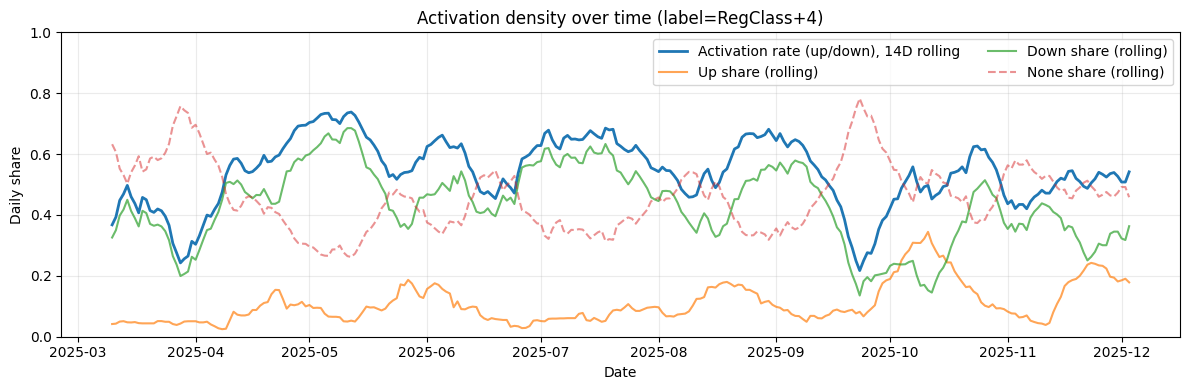

,activation_rate_mean,activation_rate_median,days,from,to
0,0.540272,0.552083,275,2025-03-04,2025-12-03


In [2]:
# Activation density (daily rates) from 2025-03-04 until latest available
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LABEL = globals().get('LABEL_COL', 'RegClass+4')
start = pd.Timestamp('2025-03-04')

# Use df_full if already loaded earlier; otherwise load the cached NO1 dataset.
if 'df_full' not in globals():
    from pathlib import Path
    import src.data.preprocess as dp
    from src.data.preprocess import Config
    ROOT = globals().get('ROOT', Path.cwd().parent)
    CACHE_NO1 = ROOT / 'data' / 'preprocessed' / 'df_NO1.pkl'
    cfg = Config()
    df_full = dp.preprocess_all(cfg=cfg, cache_path=str(CACHE_NO1) if CACHE_NO1.exists() else None)

if LABEL not in df_full.columns:
    raise KeyError(f"Missing label column '{LABEL}' in df_full")

df_window = df_full.loc[start:].copy()
y = df_window[LABEL].astype(str)
y = y[y.notna()]

# Daily class shares (up/down/none)
daily_counts = (
    y.groupby(pd.Grouper(freq='D'))
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)
daily_total = daily_counts.sum(axis=1).replace(0, np.nan)
daily_share = daily_counts.div(daily_total, axis=0)
daily_share = daily_share.fillna(0.0)

# Activation rate = P(up or down) per day
act_rate = (daily_share.get('up', 0.0) + daily_share.get('down', 0.0)).rename('activation_rate')

# Smooth to show seasonality
roll_days = 14
act_rate_s = act_rate.rolling(roll_days, min_periods=max(1, roll_days // 2)).mean()
up_s = daily_share.get('up', 0.0).rolling(roll_days, min_periods=max(1, roll_days // 2)).mean()
down_s = daily_share.get('down', 0.0).rolling(roll_days, min_periods=max(1, roll_days // 2)).mean()
none_s = daily_share.get('none', 0.0).rolling(roll_days, min_periods=max(1, roll_days // 2)).mean()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(act_rate_s.index, act_rate_s.values, label=f'Activation rate (up/down), {roll_days}D rolling', linewidth=2)
ax.plot(up_s.index, up_s.values, label='Up share (rolling)', alpha=0.7)
ax.plot(down_s.index, down_s.values, label='Down share (rolling)', alpha=0.7)
ax.plot(none_s.index, none_s.values, label='None share (rolling)', alpha=0.5, linestyle='--')
ax.set_title(f"Activation density over time (label={LABEL})")
ax.set_ylabel('Daily share')
ax.set_xlabel('Date')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.25)
ax.legend(ncol=2)
fig.tight_layout()
plt.show()

# Quick table summary
summary = pd.DataFrame({
    'activation_rate_mean': [float(act_rate.mean())],
    'activation_rate_median': [float(act_rate.median())],
    'days': [int(act_rate.shape[0])],
    'from': [str(act_rate.index.min().date()) if len(act_rate) else None],
    'to': [str(act_rate.index.max().date()) if len(act_rate) else None],
})
summary